<a href="https://colab.research.google.com/github/SiddheshDaphane/Deep_Learning_With_PyTorch/blob/master/01_PyTorch_Workflow_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn # contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

### Data (preparing and loading)

In [4]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

len(X), len(y)

(50, 50)

### Split data into training and test sets

In [5]:
train_split = int(0.8 * len(X))
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]

In [7]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

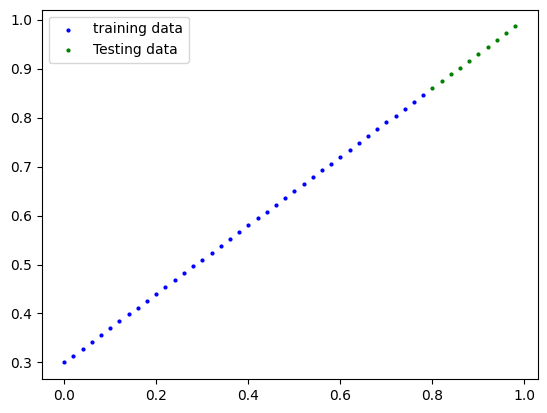

In [10]:
plt.scatter(X_train, y_train, c="b", s=4, label="training data")
plt.scatter(X_test, y_test, c="g", s=4, label = "Testing data")
plt.legend()
plt.show()

## Building a model

In [4]:
from torch import nn
import torch

In [5]:
# Create a Linear Regression model class

class LinearRegressionModel(nn.Module): # almost everything in PyTorch is a nn.Module meaning it is the base class
  def __init__(self):
    super().__init__() # Think of super().__init__() as a way to ensure your LinearRegressionModel gets all the capabilities of nn.Module.

    self.weights = nn.parameter(torch.randn(1, requires_grad = True, dtype=torch.float))
    self.bias = nn.parameter(torch.randn(1, requires_grad= True, dtype= torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias



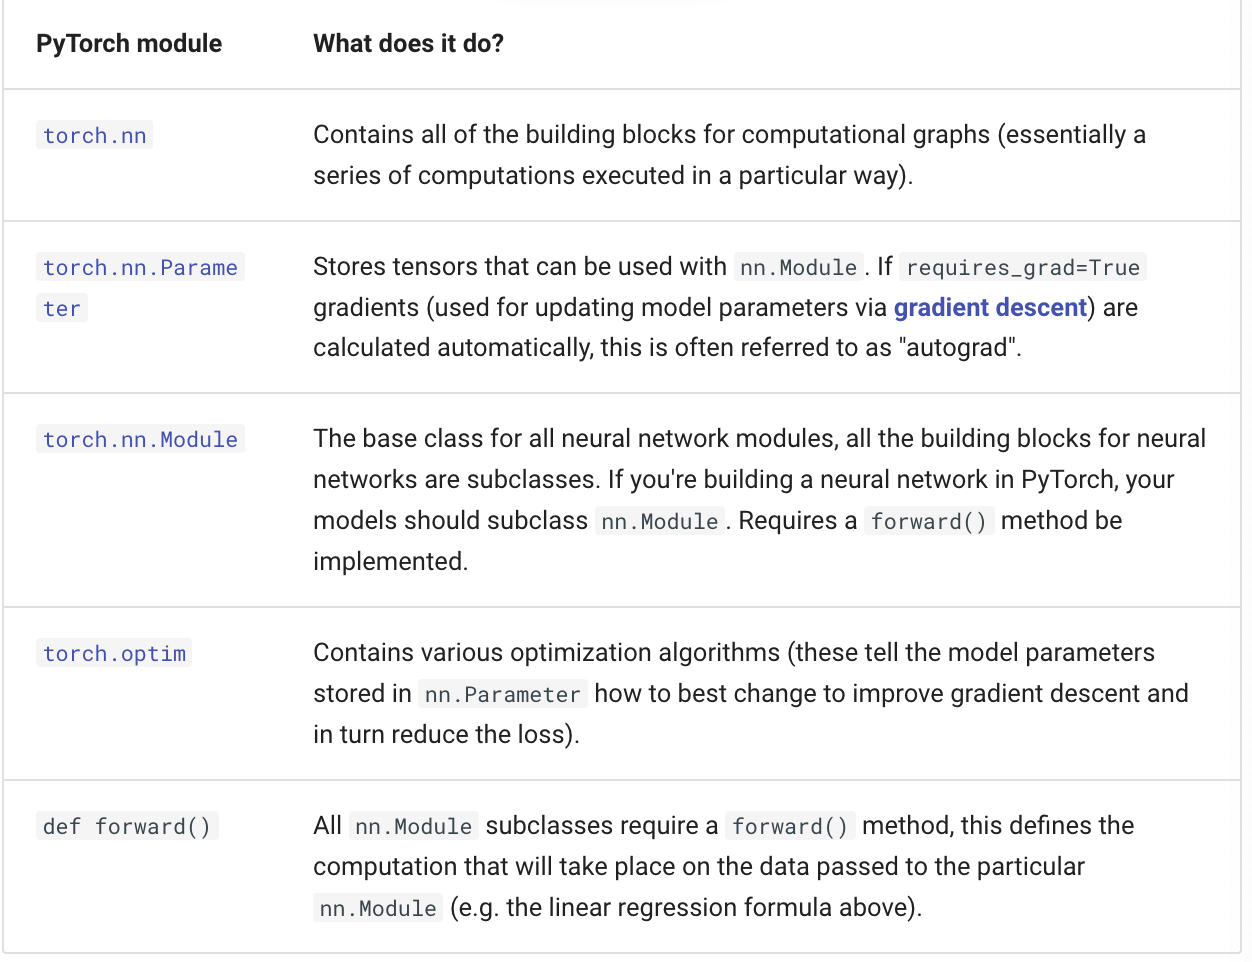

### Checking the contents of a PyTorch model